# Requirements

In [17]:
!pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


# Test Bed

In [47]:
def bandit_test_bed(arms, runs, steps, epsilon, incr_method='fixed_alpha', random_walk=False, alpha=0.1, init=0, ucb=False, c=2, desc=''):
    
    avg_R = np.zeros(steps)
    per_optim = np.zeros(steps)

    for run in tqdm(range(runs), desc=desc):
    
        #Estimated Reward per action
        Q = np.zeros(arms) + init
        #Counter of actions
        N = np.zeros(arms)
        #Initialisation
        q_star = np.array(np.random.normal(size=arms))
        
        #Random Walk
        if random_walk:
            #Equal Initialisation
            q_star = np.array([q_star[0]]*arms)
        
        #Optimal action
        optim_a = np.argmax(q_star)

        for step in range(steps):
            #Epsilon-greedy
            if np.random.uniform() < epsilon:
                a = np.random.randint(arms)
            else:
                a = np.argmax(Q)
            
            if ucb:
                if 0 in N:
                    a = np.where(N==0)[0][0]
                else:
                    a = np.argmax(Q + c * np.sqrt(np.log(step)/N))
                
            #Update action counter
            N[a] += 1
            
            if incr_method == 'sample_mean':
                alpha = 1 / N[a]
            
            #Reward
            R = np.random.normal(loc=q_star[a])
            #Update Estimate
            Q[a] += alpha * (R - Q[a]) 

            if a == optim_a:
                per_optim[step] += 1

            avg_R[step] += R
            #Random Walk
            if random_walk:
                #Non-stationarity: Expected reward random walk
                q_star += np.random.normal(scale=0.01, size=arms)
                #Optimal action
                optim_a = np.argmax(q_star)

    avg_R /= runs
    per_optim = 100 * np.cumsum(per_optim) / (runs * np.arange(1, steps+1))
    
    return avg_R, per_optim

# Exercises

## Do Exercise: 2.5

### Experiment

In [3]:
arms = 10
runs = 2000
steps = 10000
epsilon = 0.1
random_walk = True

incr_method = 'sample_mean'
avg_R_sample, per_optim_sample = bandit_test_bed(arms=arms, runs=runs, steps=steps, 
                                                 epsilon=epsilon, incr_method=incr_method, 
                                                 random_walk=random_walk, desc=incr_method)

incr_method = 'fixed_alpha'
alpha = 0.1
avg_R_fixed, per_optim_fixed = bandit_test_bed(arms=arms, runs=runs, steps=steps, 
                                               epsilon=epsilon, incr_method=incr_method, 
                                               random_walk=random_walk, alpha=alpha, desc=incr_method)

fixed_alpha: 100%|██████████| 2000/2000 [04:29<00:00,  7.43it/s]


### Plot

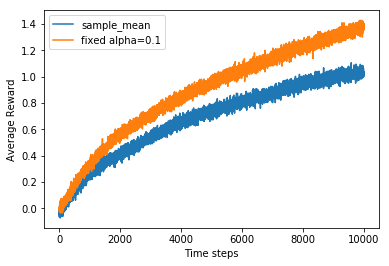

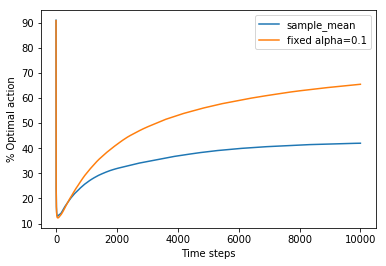

In [52]:
plt.figure()
plt.plot(avg_R_sample, label='sample_mean')
plt.plot(avg_R_fixed, label='fixed alpha='+str(alpha))
plt.xlabel('Time steps')
plt.ylabel('Average Reward')
plt.legend()

plt.figure()
plt.plot(per_optim_sample, label='sample_mean')
plt.plot(per_optim_fixed, label='fixed alpha='+str(alpha))
plt.xlabel('Time steps')
plt.ylabel('% Optimal action')
plt.legend()

## Generate Fig. 2.3 and do Exercise 2.6. Repeat Fig. 2.3 for non-stationary. Explain what you see.

### Generate Fig. 2.3

In [36]:
arms = 10
runs = 2000
steps = 1000
incr_method = 'fixed_alpha'
alpha = 0.1
random_walk = False

epsilon = 0.0
init = 5
avg_R_optim, per_optim_optim = bandit_test_bed(arms=arms, runs=runs, steps=steps,
                                               epsilon=epsilon, incr_method=incr_method, 
                                               random_walk=random_walk, alpha=alpha, 
                                               desc='optimistic_stat', init=init)
epsilon = 0.1
init = 0
avg_R_epsilon, per_optim_epsilon = bandit_test_bed(arms=arms, runs=runs, steps=steps, 
                                               epsilon=epsilon, incr_method=incr_method, 
                                               random_walk=random_walk, alpha=alpha, 
                                                 desc='epsilon_stat', init=init)

epsilon_stat: 100%|██████████| 2000/2000 [00:13<00:00, 145.59it/s]


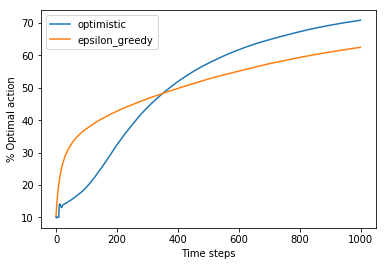

In [53]:
plt.figure()
plt.plot(per_optim_optim, label='optimistic')
plt.plot(per_optim_epsilon, label='epsilon_greedy')
plt.xlabel('Time steps')
plt.ylabel('% Optimal action')
plt.legend()

### Do Exercise 2.6

### Repeat Fig. 2.3 for non-stationary

In [38]:
arms = 10
runs = 2000
steps = 1000
incr_method = 'fixed_alpha'
alpha = 0.1
random_walk = True

epsilon = 0.0
init = 5
avg_R_optim_non, per_optim_optim_non = bandit_test_bed(arms=arms, runs=runs, steps=steps, 
                                               epsilon=epsilon, incr_method=incr_method, desc='optimistic_nonstat',
                                               random_walk=random_walk, alpha=alpha, init=init)
epsilon = 0.1
init = 0
avg_R_epsilon_non, per_optim_epsilon_non = bandit_test_bed(arms=arms, runs=runs, steps=steps, 
                                               epsilon=epsilon, incr_method=incr_method, desc='epsilon_nonstat',
                                               random_walk=random_walk, alpha=alpha, init=init)

epsilon_nonstat: 100%|██████████| 2000/2000 [00:28<00:00, 70.90it/s]


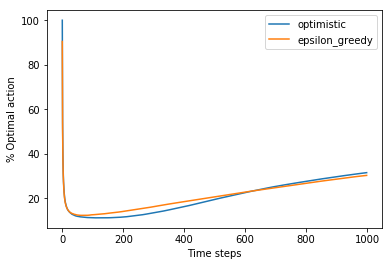

In [50]:
plt.figure()
plt.plot(per_optim_optim_non, label='optimistic')
plt.plot(per_optim_epsilon_non, label='epsilon_greedy')
plt.xlabel('Time steps')
plt.ylabel('% Optimal action')
plt.legend()

### Explain what you see.

Opitmistic Initial Value method performs poorer than epsilon-greedy initially but proves to be better in the long run. Optimistic Initial Values ensure that the agent explores all the arms initially to have a better estimate of the expected return of each arm before exploiting. Exploring less can lead to exploitation on poorer estimates.

## Exercise 2.7. Making constant step-size independent of Q_1, propose a method that does the above. Demonstrate using analysis.

Verifying the method is not biased on $Q_1$ <br>

$\beta_n \ \dot{=} \ \alpha\ /\ \bar O_n$ <br>

$\bar O_n \ \dot{=} \ \bar O_{n-1} + \alpha\ (1 - \bar O_{n-1})$ <br>

$\bar O_0 \ \dot{=} \ 0$ <br>

$\bar O_1 = \bar O_0 + \alpha\ (1 - \bar O_0) = 0 + \alpha\ (1 - 0) = \alpha$ <br>

$\beta_1 = \alpha\ /\ \bar O_1\ = \alpha\ /\ \alpha = 1$ <br>

$Q_{n+1} = Q_n + \beta_n [R_n + Q_n]$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n) Q_n$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n)\ [\beta_{n-1} R_{n-1} + (1 - \beta_{n-1}) Q_{n-1}]$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n) \beta_{n-1} R_{n-1} + (1 - \beta_n) (1 - \beta_{n-1}) Q_{n-1}$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n) \beta_{n-1} R_{n-1} + (1 - \beta_n) (1 - \beta_{n-1}) \beta_{n-2} R_{n-2} +\ ...\ + (1 - \beta_{n})(1 - \beta_{n-1})(1 - \beta_{n-2})\ \ ...\ (1 - \beta_2) Q_2$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n) \beta_{n-1} R_{n-1} + (1 - \beta_n) (1 - \beta_{n-1}) \beta_{n-2} R_{n-2} +\ ...\ + (1 - \beta_{n})(1 - \beta_{n-1})(1 - \beta_{n-2})\ \ ...\ (1 - \beta_2)\ [\beta_1 R_1 + (1 - \beta_1) Q_1]$ <br>
$\quad \quad = \beta_n R_n + (1 - \beta_n) \beta_{n-1} R_{n-1} + (1 - \beta_n) (1 - \beta_{n-1}) \beta_{n-2} R_{n-2} +\ ...\ + (1 - \beta_{n})(1 - \beta_{n-1})(1 - \beta_{n-2})\ \ ...\ (1 - \beta_2)\ \beta_1 R_1$ <br>
<br>
This shows that the return is independent of $Q_1$ 

## Compare UCB to Optimistic Value and e-greedy for both Stationary & Non-Stationary case.

### Experiment

In [48]:
arms = 10
runs = 2000
steps = 1000
incr_method = 'fixed_alpha'
alpha = 0.1
ucb = True
c = 2
epsilon = 0.0

random_walk = False
avg_R_ucb, per_optim_ucb = bandit_test_bed(arms=arms, runs=runs, steps=steps,
                                               epsilon=epsilon, incr_method=incr_method, 
                                               random_walk=random_walk, alpha=alpha,
                                               init=init, ucb=ucb, c=c, desc='ucb_stat')

random_walk = True
avg_R_ucb_non, per_optim_ucb_non = bandit_test_bed(arms=arms, runs=runs, steps=steps,
                                               epsilon=epsilon, incr_method=incr_method, 
                                               random_walk=random_walk, alpha=alpha,
                                               init=init, ucb=ucb, c=c, desc='ucb_nonstat')

ucb_nonstat: 100%|██████████| 2000/2000 [00:59<00:00, 33.50it/s]


### Plot

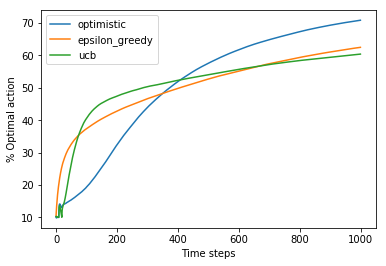

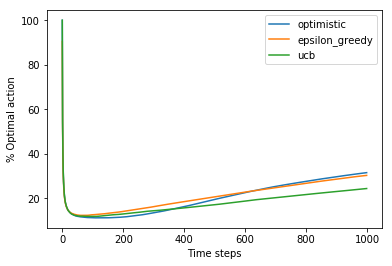

In [54]:
plt.figure()
plt.plot(per_optim_optim, label='optimistic')
plt.plot(per_optim_epsilon, label='epsilon_greedy')
plt.plot(per_optim_ucb, label='ucb')
plt.xlabel('Time steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.figure()
plt.plot(per_optim_optim_non, label='optimistic')
plt.plot(per_optim_epsilon_non, label='epsilon_greedy')
plt.plot(per_optim_ucb_non, label='ucb')
plt.xlabel('Time steps')
plt.ylabel('% Optimal action')
plt.legend()

### Theoretical Explanation